In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import joblib

# Helper functions

In [2]:
def compute_skew(row):
    row_without_nan = row.dropna()
    if len(row_without_nan) >= 3:
        return row_without_nan.skew()
    else:
        return 0
def compute_kurt(row):
    row_without_nan = row.dropna()
    if len(row_without_nan) >= 3:
        return row_without_nan.kurt()
    else:
        return 3

def cal_std(row):
  #Standard deviration
  return np.nanstd(row)

def cal_diff(row):
    notna = row.notna()  # Xác định vị trí của giá trị not NaN trong hàng
    tmp=row[notna]
    if len(tmp)>=2:
      diff = tmp[-1] - tmp[- 2] 
      return diff
    else: 
      return 0 

def feature_engineering(df):
  dtb_columns = [col for col in df.columns if col.endswith('_dtbhk')]
  df['dtb_mean']= np.nanmean(df[dtb_columns],axis=1)
  df['dtb_std']= df[dtb_columns].apply(cal_std, axis=1)
  df['dtb_diff']=df[dtb_columns].apply(cal_diff, axis=1)
#  df['dtb_skew']= df[dtb_columns].apply(compute_skew, axis= 1)
#  df['dtb_kurt']= df[dtb_columns].apply(compute_kurt, axis= 1)
#  df['ratio_greater7.5']=df[dtb_columns].apply(lambda row: row[row.ge(7.5)].count() / row.dropna().count(), axis=1)
#  df['ratio_greater5']=df[dtb_columns].apply(lambda row: row[row.ge(5)].count() / row.dropna().count(), axis=1)

  drl_columns = [col for col in df.columns if col.endswith('_drl')]

  df['drl_mean']= np.nanmean(df[drl_columns],axis=1)
  df['drl_std']= df[drl_columns].apply(cal_std, axis=1)
#  df['drl_skew']= df[drl_columns].apply(compute_skew, axis= 1)
#  df['drl_kurt']= df[drl_columns].apply(compute_kurt, axis= 1)
#  df['ratio_excellent']=df[drl_columns].apply(lambda row: row[row.ge(90)].count() / row.dropna().count(), axis=1)
#  df['ratio_undergood']=df[drl_columns].apply(lambda row: row[row.le(80)].count() / row.dropna().count(), axis=1)

  sotchk_columns = [col for col in df.columns if col.endswith('_sotchk')]
  df['sotchk_mean']= np.nanmean(df[sotchk_columns],axis=1)

  #df['sotchk_std']= np.nanstd(df[drl_columns],axis=1)
  #df['sotchk_skew']= df[drl_columns].apply(compute_skew, axis= 1)
  #df['sotchk_kurt']= df[drl_columns].apply(compute_skew, axis= 1)
  return df.drop(dtb_columns+drl_columns+sotchk_columns, axis=1)
 
 
def evaluate(y_true, y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    pre = metrics.precision_score(y_true, y_pred, average='macro')
    re = metrics.recall_score(y_true, y_pred, average='macro')
    f1 = metrics.f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {pre}")
    print(f"Recall: {re}")
    print(f"F1-score: {f1}")

    print(metrics.classification_report(y_true, y_pred))
    print()
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='pred')
    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16}, fmt='.3f')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

cat_features=['CCHV_1', 'CCHV_2', 'CCHV_3', 'CCHV_4', 'CCHV_5', 'CCHV_6', 'pass_avsc']

# **Data Phase**

In [3]:
train_data=pd.read_excel('data/train.xlsx')
test_data_1=pd.read_excel('data/test_1.xlsx') 
test_data_2=pd.read_excel('data/test_2.xlsx')

## Preprocessing

In [4]:
train_data = feature_engineering(train_data)
test_data_1 = feature_engineering(test_data_1)
test_data_2 = feature_engineering(test_data_2)

In [5]:
# In order to treat 'nan' as a value
train_data[cat_features] = train_data[cat_features].fillna('')
test_data_1[cat_features] = test_data_1[cat_features].fillna('')
test_data_2[cat_features] = test_data_2[cat_features].fillna('')

train_data[cat_features] = train_data[cat_features].astype(str)
test_data_1[cat_features] = test_data_1[cat_features].astype(str)
test_data_2[cat_features] = test_data_2[cat_features].astype(str)

In [6]:
# Encode
cchv_le = preprocessing.LabelEncoder()
cchv_le.fit(train_data[['CCHV_1']].values.ravel())

for cl in cat_features:
  if cl != 'pass_avsc':
    train_data[cl] = cchv_le.transform(train_data[cl].astype('O'))
    test_data_1[cl] = cchv_le.transform(test_data_1[cl].astype('O'))
    test_data_2[cl] = cchv_le.transform(test_data_2[cl].astype('O'))

avsc_le = preprocessing.LabelEncoder()
avsc_le.fit(train_data['pass_avsc'].values.ravel())
train_data['pass_avsc'] = avsc_le.transform(train_data['pass_avsc'].astype('O'))
test_data_1['pass_avsc'] = avsc_le.transform(test_data_1['pass_avsc'].astype('O'))
test_data_2['pass_avsc'] = avsc_le.transform(test_data_2['pass_avsc'].astype('O'))

In [7]:
print(f"CCHV encoded: {list(cchv_le.classes_)}")

CCHV encoded: ['', 'Bị cảnh cáo vì ĐTB học kỳ', 'Bị cảnh cáo vì ĐTB và trễ học phí', 'Bị cảnh cáo vì đtb 2 học kỳ liên tiếp < 4', 'Bị cảnh cáo vì đóng học phí trễ', 'Được xem xét hạ mức']


In [8]:
print(f"AVSC state encoded: {list(avsc_le.classes_)}")

AVSC state encoded: ['', '0.0', '1.0']


In [9]:
if not os.path.exists('./resource'):
    os.makedirs('resource')
    
joblib.dump(cchv_le, "resource/cchv_le.joblib")
joblib.dump(avsc_le, "resource/avsc_le.joblib")

['resource/avsc_le.joblib']

In [10]:
train_data = train_data.dropna()
test_data_1 = test_data_1.dropna()
test_data_2 = test_data_2.dropna()

## Visualize data

In [11]:
num_cols = [col for col in list(train_data.columns) if col not in cat_features]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


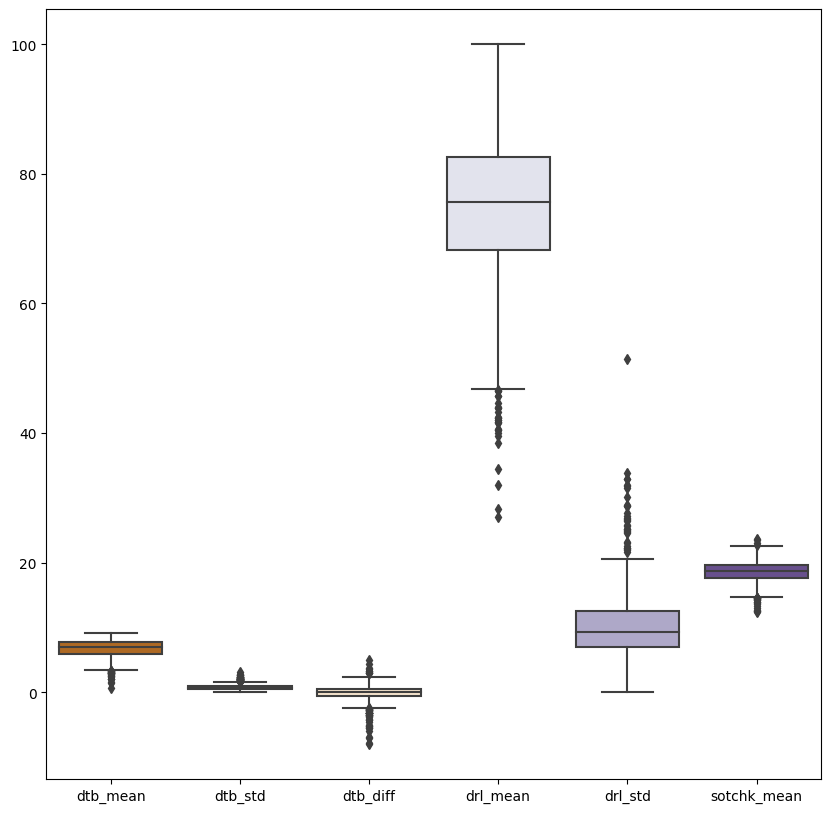

In [12]:
plt.figure(figsize=(10,10))
# t = test_data_2.drop(['label'], axis=1)
sns.color_palette("tab10")
t = test_data_2[num_cols]
t = t.drop(['label'], axis=1)
sns.boxplot(t, palette="PuOr")
plt.show()

<Figure size 2000x1000 with 0 Axes>

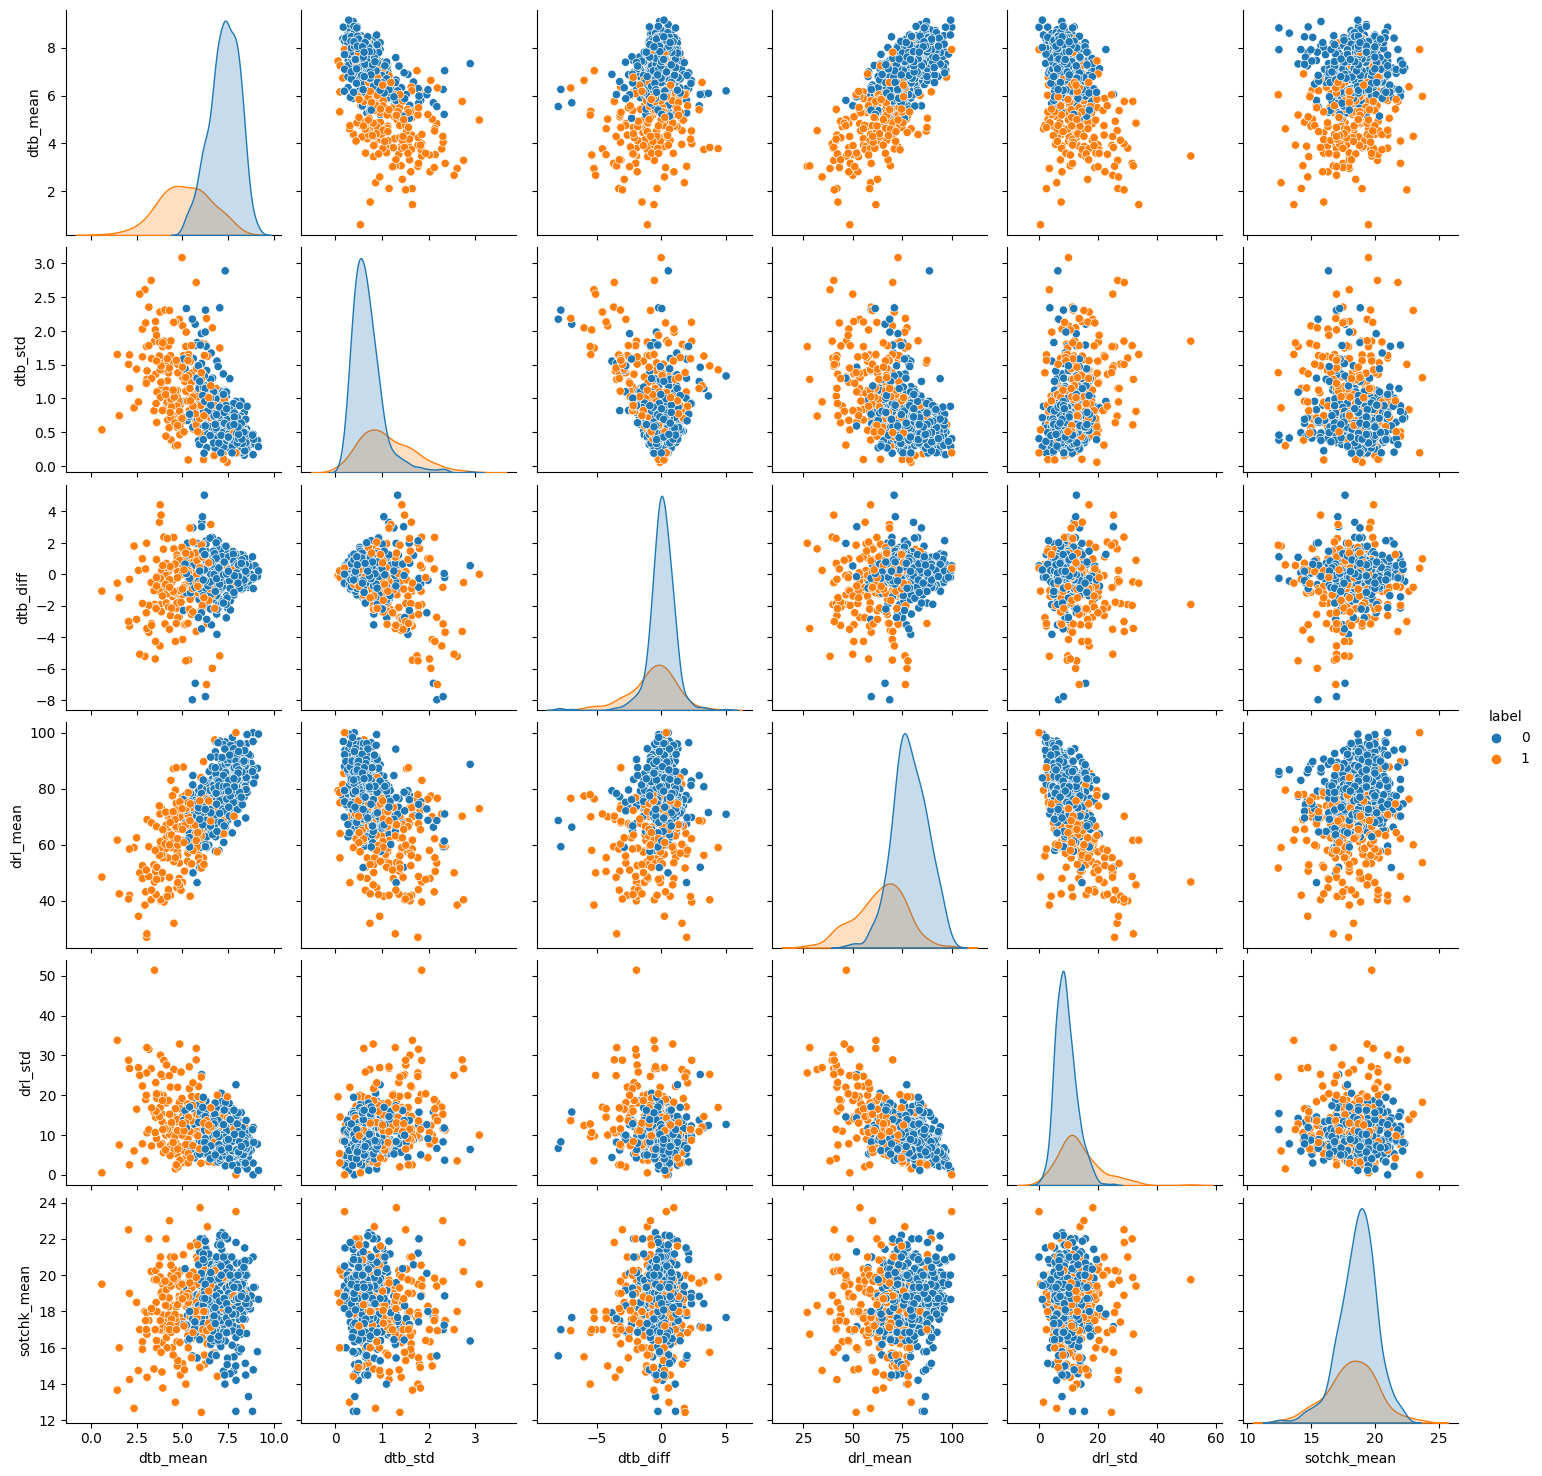

In [13]:
t = test_data_2[num_cols]
plt.figure(figsize=(20,10))
sns.pairplot(data=t, hue='label')
plt.show()

<Figure size 2000x1000 with 0 Axes>

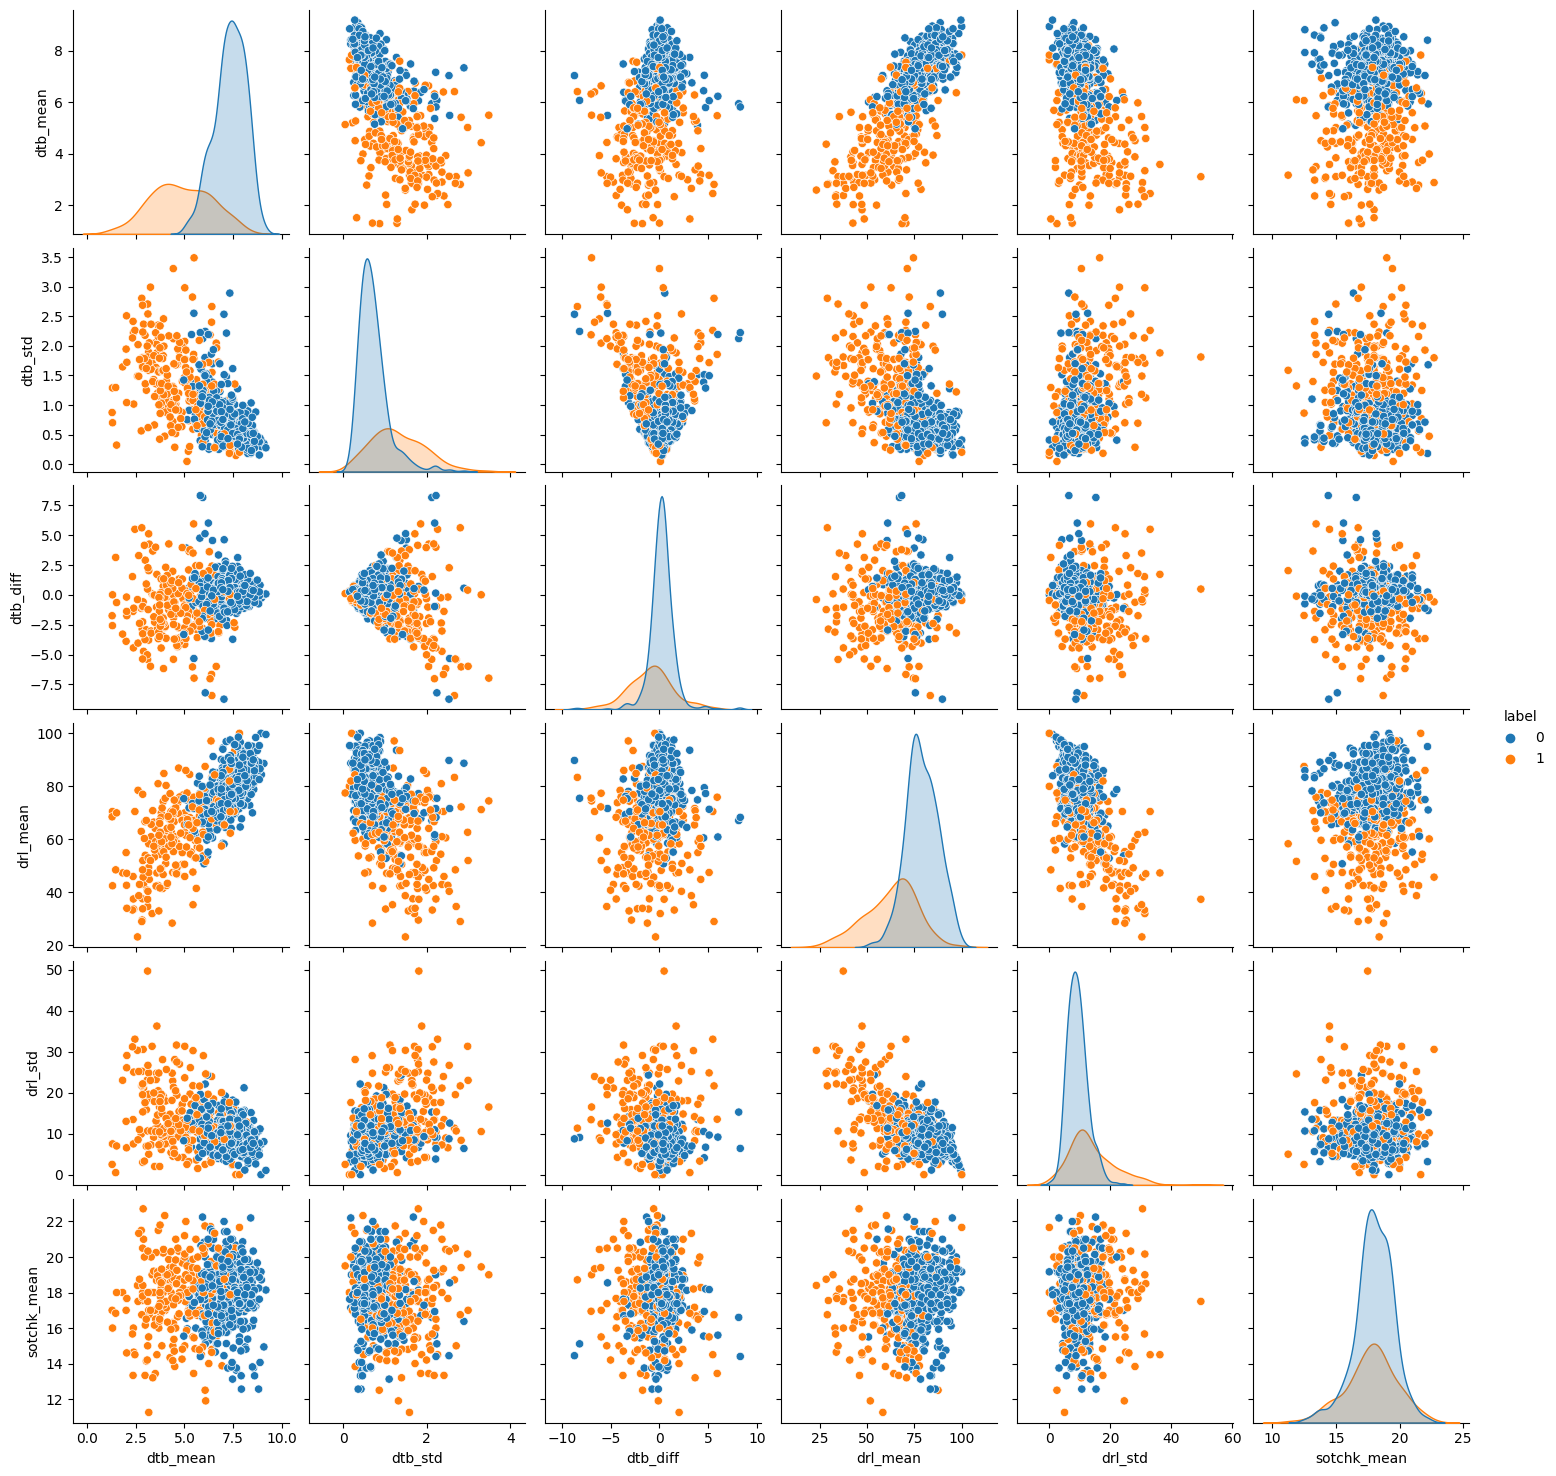

In [14]:
t = test_data_1[num_cols]
plt.figure(figsize=(20,10))
sns.pairplot(data=t, hue='label')
plt.show()

## Split the data

In [15]:
X_train= train_data.drop(['label'], axis=1).copy()
y_train= train_data['label'].copy()

X_test_1=test_data_1.drop(['label'], axis=1).copy()
y_test_1= test_data_1['label'].copy()
X_test_2=test_data_2.drop(['label'], axis=1).copy()
y_test_2= test_data_2['label'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test_1 shape: {X_test_1.shape}")
print(f"y_test_1 shape: {y_test_1.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"y_test_2 shape: {y_test_2.shape}")

X_train shape: (1891, 13)
y_train shape: (1891,)
X_test_1 shape: (804, 13)
y_test_1 shape: (804,)
X_test_2 shape: (772, 13)
y_test_2 shape: (772,)


In [16]:
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test1 = scaler.transform(X_test_1)
X_test2 = scaler.transform(X_test_2)

In [17]:
if not os.path.exists('./resource'):
    os.makedirs('resource')

joblib.dump(scaler, "resource/scaler.joblib")

['resource/scaler.joblib']

# **Models Phase**

## K Nearest Neighbors

[On Test 1]
Accuracy: 0.8768656716417911
Precision: 0.8764592279732137
Recall: 0.8376876707698375
F1-score: 0.8528155978927164
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       542
           1       0.88      0.73      0.79       262

    accuracy                           0.88       804
   macro avg       0.88      0.84      0.85       804
weighted avg       0.88      0.88      0.87       804




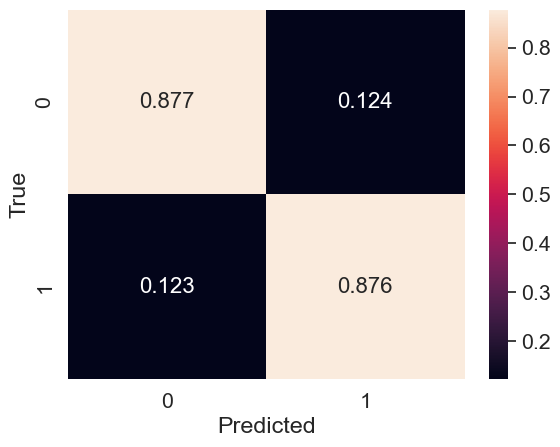

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8575129533678757
Precision: 0.8516625991458207
Recall: 0.7959088721321996
F1-score: 0.8162016154865073
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       542
           1       0.84      0.64      0.73       230

    accuracy                           0.86       772
   macro avg       0.85      0.80      0.82       772
weighted avg       0.86      0.86      0.85       772




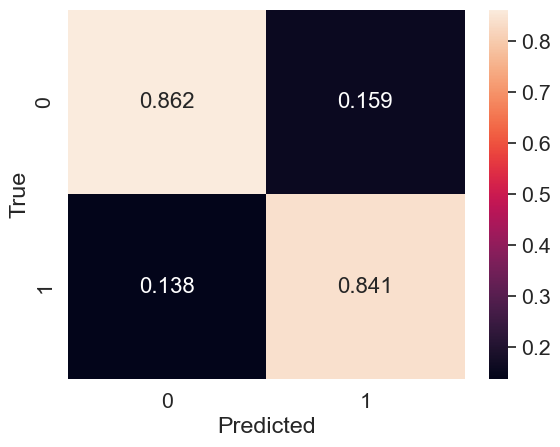

In [18]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

### Grid Search

Best hyperparameters:
	{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
*********************************************************************
Train - Test with best hyperparameters

[On Test 1]
Accuracy: 0.8743781094527363
Precision: 0.8733032917513877
Recall: 0.8348567645981804
F1-score: 0.8498421756279229
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       542
           1       0.87      0.72      0.79       262

    accuracy                           0.87       804
   macro avg       0.87      0.83      0.85       804
weighted avg       0.87      0.87      0.87       804




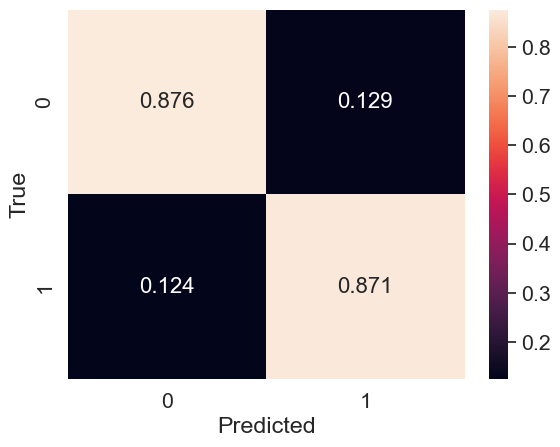

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8639896373056994
Precision: 0.8550347621897878
Recall: 0.8092812449863629
F1-score: 0.8269926472942257
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       542
           1       0.84      0.67      0.75       230

    accuracy                           0.86       772
   macro avg       0.86      0.81      0.83       772
weighted avg       0.86      0.86      0.86       772




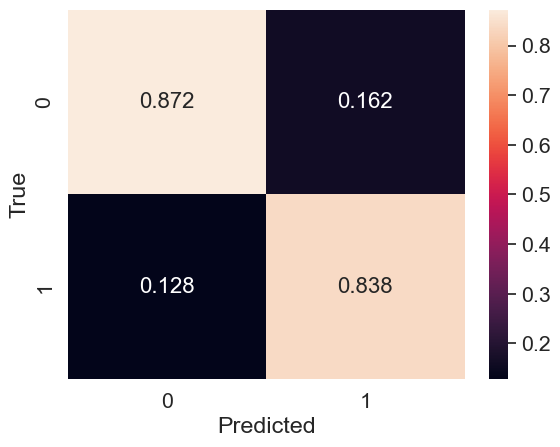

In [19]:
weights = ['uniform', 'distance']
n_neighbors = list(range(1,62))
p=[1,2]
hyperparameters = dict(n_neighbors=n_neighbors, p=p, weights=weights)
knn_2 = KNeighborsClassifier()
scoring = metrics.make_scorer(metrics.f1_score, average='macro')
clf = GridSearchCV(knn_2, hyperparameters, scoring = scoring, n_jobs=-1)
best_model_KNN = clf.fit(X_train, y_train)
best_params = best_model_KNN.best_params_

print(f"Best hyperparameters:\n\t{best_params}")
print('*' * 69)
print("Train - Test with best hyperparameters\n")

model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

## Decision Tree

[On Test 1]
Accuracy: 0.8694029850746269
Precision: 0.8511803940035001
Recall: 0.8518703698487367
F1-score: 0.8515235457063712
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       542
           1       0.80      0.80      0.80       262

    accuracy                           0.87       804
   macro avg       0.85      0.85      0.85       804
weighted avg       0.87      0.87      0.87       804




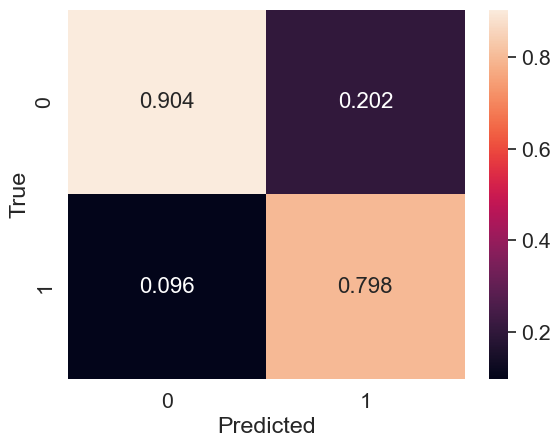

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8238341968911918
Precision: 0.7889419428282317
Recall: 0.7931974971923632
F1-score: 0.7909974758533924
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       542
           1       0.70      0.72      0.71       230

    accuracy                           0.82       772
   macro avg       0.79      0.79      0.79       772
weighted avg       0.83      0.82      0.82       772




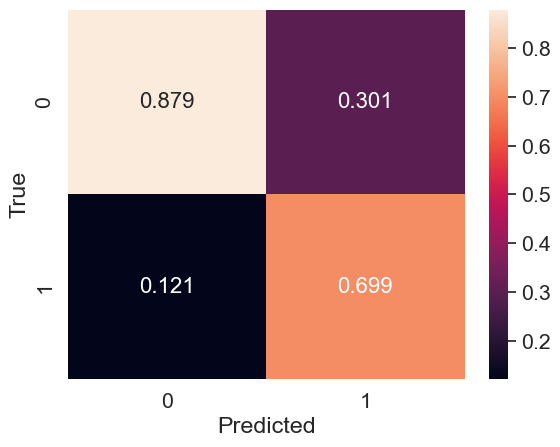

In [20]:
model = DecisionTreeClassifier() 
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

### Grid Search

Best hyperparameters:
	{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5}
*********************************************************************
Train - Test with best hyperparameters

[On Test 1]
Accuracy: 0.8681592039800995
Precision: 0.8586628888353026
Recall: 0.8351736570800823
F1-score: 0.8451362489914886
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       542
           1       0.84      0.74      0.79       262

    accuracy                           0.87       804
   macro avg       0.86      0.84      0.85       804
weighted avg       0.87      0.87      0.87       804




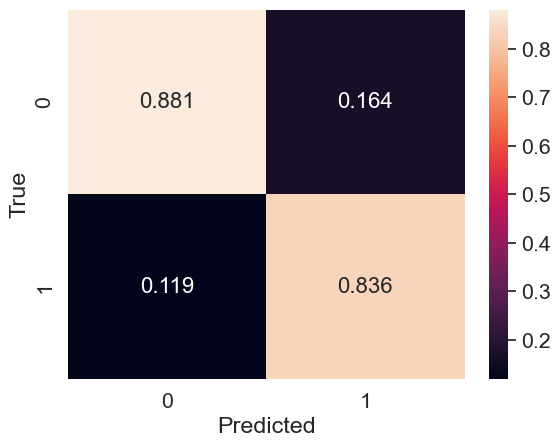

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8588082901554405
Precision: 0.8363239306924838
Recall: 0.8193566500882401
F1-score: 0.8270065354639891
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       542
           1       0.79      0.72      0.75       230

    accuracy                           0.86       772
   macro avg       0.84      0.82      0.83       772
weighted avg       0.86      0.86      0.86       772




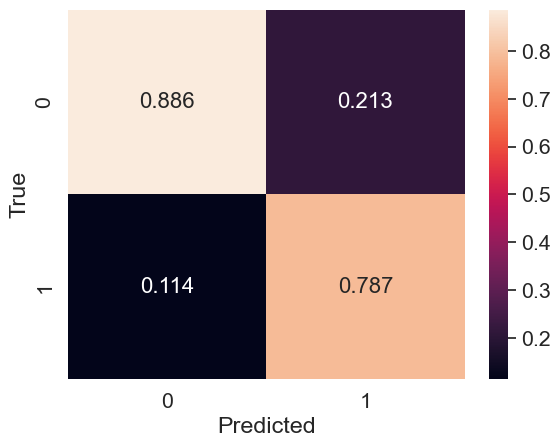

In [21]:
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Định nghĩa metric là f1_score macro
scoring = metrics.make_scorer(metrics.f1_score, average='macro')

# Tạo GridSearchCV
model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best hyperparameters:\n\t{best_params}")
print('*' * 69)
print("Train - Test with best hyperparameters\n")

model = DecisionTreeClassifier(**best_params)
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

## LightGBM

[On Test 1]
Accuracy: 0.8880597014925373
Precision: 0.8820062977957714
Recall: 0.858806794174812
F1-score: 0.8688065676491065
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       542
           1       0.87      0.77      0.82       262

    accuracy                           0.89       804
   macro avg       0.88      0.86      0.87       804
weighted avg       0.89      0.89      0.89       804




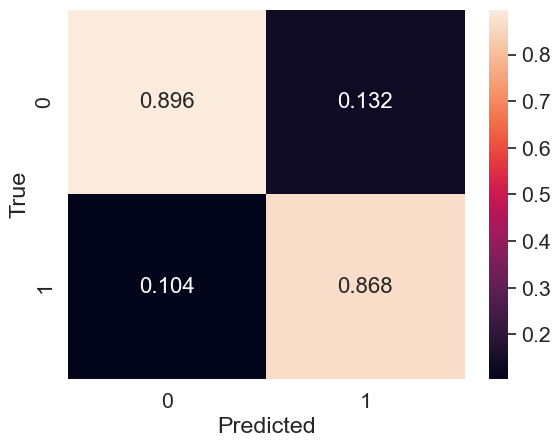

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.866580310880829
Precision: 0.851083515307778
Recall: 0.8211374939836356
F1-score: 0.833765039146205
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       542
           1       0.82      0.71      0.76       230

    accuracy                           0.87       772
   macro avg       0.85      0.82      0.83       772
weighted avg       0.86      0.87      0.86       772




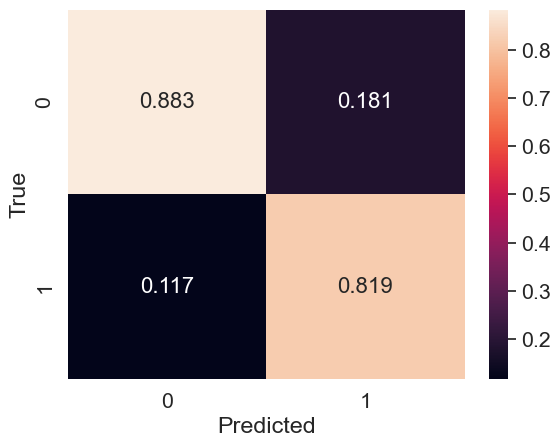

In [22]:
model = lgb.LGBMClassifier() 
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

In [23]:
if not os.path.exists('./model'):
    os.makedirs('model')

joblib.dump(model, "model/best_model.joblib")

['model/best_model.joblib']

### Grid Search

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_dat

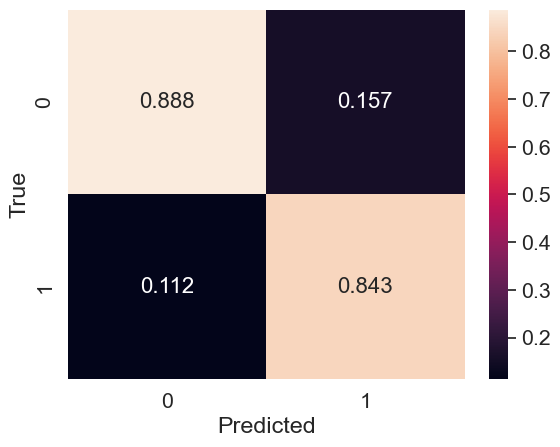

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8588082901554405
Precision: 0.8418141690576031
Recall: 0.810596823359538
F1-score: 0.8235739340278725
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       542
           1       0.81      0.69      0.74       230

    accuracy                           0.86       772
   macro avg       0.84      0.81      0.82       772
weighted avg       0.86      0.86      0.86       772




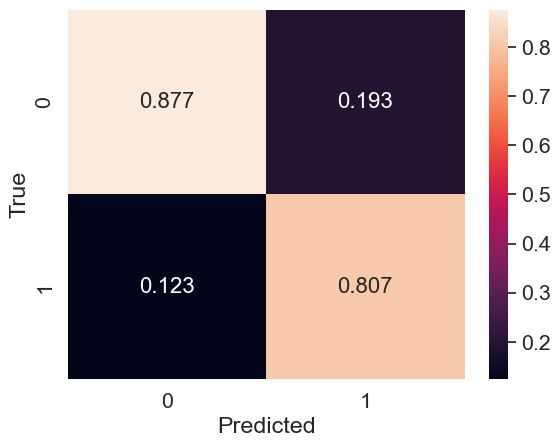

In [24]:
model = lgb.LGBMClassifier()

parameters = {
    'num_leaves': [10, 20, 30, 40, 50],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 5, 10, 15, 20],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
scoring = metrics.make_scorer(metrics.f1_score, average='macro')

grid_search = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best hyperparameters:\n\t{best_params}")
print('*' * 69)
print("Train - Test with best hyperparameters\n")

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

## Logistic Regression

[On Test 1]
Accuracy: 0.8967661691542289
Precision: 0.8970754173862983
Recall: 0.864278471028985
F1-score: 0.8777638768553304
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       542
           1       0.90      0.77      0.83       262

    accuracy                           0.90       804
   macro avg       0.90      0.86      0.88       804
weighted avg       0.90      0.90      0.89       804




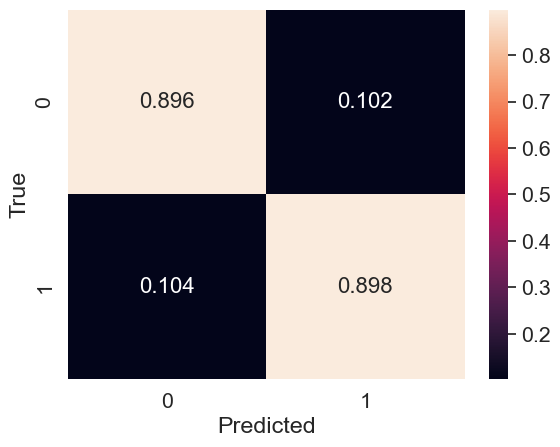

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8821243523316062
Precision: 0.873612407234591
Recall: 0.8372132199582866
F1-score: 0.8522798717342164
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       542
           1       0.86      0.73      0.79       230

    accuracy                           0.88       772
   macro avg       0.87      0.84      0.85       772
weighted avg       0.88      0.88      0.88       772




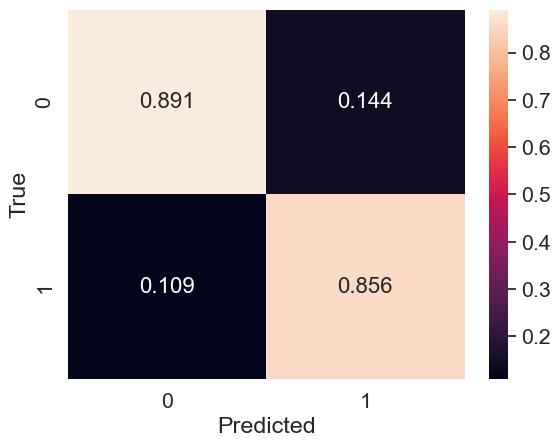

In [25]:
model = LogisticRegression(max_iter=5000) 
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)

### Grid Search

Best hyperparameters:
	{'C': 3, 'class_weight': None}
*********************************************************************
Train - Test with best hyperparameters

[On Test 1]
Accuracy: 0.8955223880597015
Precision: 0.8960745073891625
Recall: 0.8623700740824203
F1-score: 0.8761470918333664
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       542
           1       0.90      0.77      0.83       262

    accuracy                           0.90       804
   macro avg       0.90      0.86      0.88       804
weighted avg       0.90      0.90      0.89       804




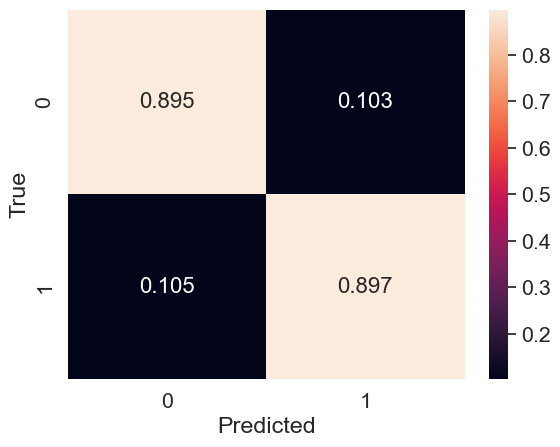

---------------------------------------------------------------------
[On Test 2]
Accuracy: 0.8821243523316062
Precision: 0.873612407234591
Recall: 0.8372132199582866
F1-score: 0.8522798717342164
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       542
           1       0.86      0.73      0.79       230

    accuracy                           0.88       772
   macro avg       0.87      0.84      0.85       772
weighted avg       0.88      0.88      0.88       772




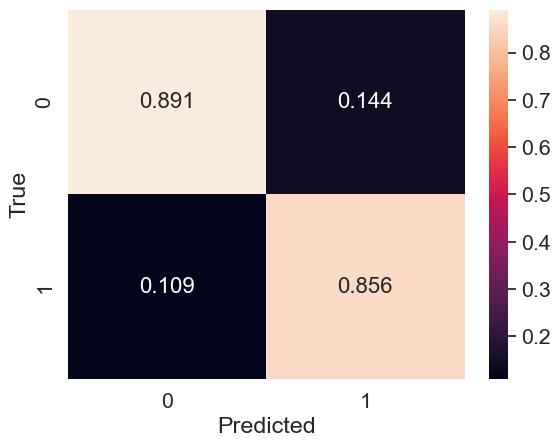

In [26]:
model = LogisticRegression()

parameters = {
    'C': [1,3,5,10],
    'class_weight': ['balanced', None]
}
scoring = metrics.make_scorer(metrics.f1_score, average='macro')

grid_search = GridSearchCV(model, parameters, scoring=scoring, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best hyperparameters:\n\t{best_params}")
print('*' * 69)
print("Train - Test with best hyperparameters\n")

model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

pred_1 = model.predict(X_test1)
pred_2 = model.predict(X_test2)

print("[On Test 1]")
evaluate(y_test_1, pred_1)
print('-' * 69)
print("[On Test 2]")
evaluate(y_test_2, pred_2)